# Graph Partitioning on Dirac

#### Device: Dirac-1

## Introduction

One area of study from graph theory is the graph partitioning problem. Graph partitioning is used in a range of applications. In this demo, we aim to execute and plot the optimal split of two small graph instances achieved via Qatalyst graph partitioning solver, using Dirac-1.

## Objective

##### Partition a graph into $\textit{k}$ disjoint collections of nodes, while minimizing the number of inter-partition edges.

For example, the figure below is an illustration of the Zachary Karate Club social interactions and the partition found using DWave's quantum annealing device.

<img src="figures/zachary_kc_graph.png" width="600" height="450">

## Qatalyst

### I. Imports

Required and complementary imports:

In [7]:
from qci_client import QciClient
import helpers
import numpy as np
import networkx as nx
import sys, os

import matplotlib.pyplot as plt
%matplotlib inline

### II. Problem formulation

Example problem 1 - an undirected barbell graph instance (formulated via NetworkX):
- 8 nodes per cluster
- 2 nodes connected by edges between the clusters

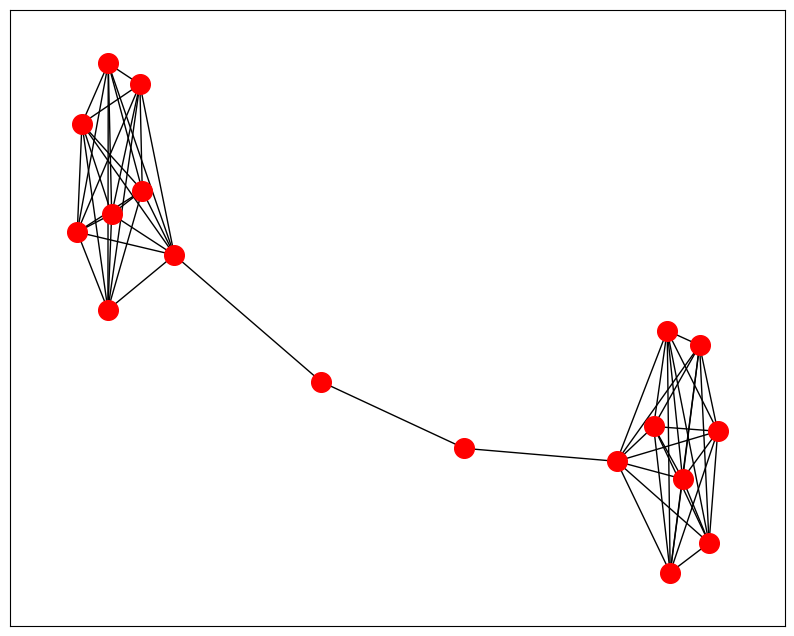

In [8]:
barbell_graph = nx.barbell_graph(8, 2)
helpers.plot_graph_plain(barbell_graph)

### III. Client request parameters
- `alpha`, `beta`: hyperparameters for weighted importance of objective (`alpha`) versus constraint (`beta`)
- `n_samples`: number of samples (size of distribution to collect)
- `num_partitions`: number of partitions
- `sampler_type`: `"eqc1"` or `"csample"`
- `job_type`: `"graph-partitioning"`

In [9]:
# Constraint-objective hyperparameters
alpha = 5
beta = 1
# Num samples
n_samples = 1
# Number of partitions
num_partitions = 2

# Job and sampler type
sampler_type = "dirac-1"

job_type = "graph-partitioning"

### IV. Instantiate client, pass job parameters, and execute

- Requirement: `QciClient` client token
- Preliminary: Use `upload_file()` of `QciClient` class instance to upload the problem and retrieve `file_id` 
- Next: Pass `file_id`, alongside the above parameters, to request body call, `build_job_body()` of `QciClient` class
- Last: Execute job with `process_job()` of `QciClient` class instance

In [10]:
token="your_token"
url = "https://api.qci-prod.com"
q1 = QciClient(api_token=token, url=url)

In [ ]:
graph_file = {"file_name": "gp_example", "file_config": {"graph": {"data": barbell_graph}}}
file_id = q1.upload_file(file=graph_file)["file_id"]
job_body = q1.build_job_body(job_type=job_type, graph_file_id=file_id, 
                             job_tags=["partition", "example", "!"], 
                             job_params={"device_type": sampler_type,
                                         "num_samples": n_samples, 
                                         "alpha": alpha,
                                         "beta": beta,
                                         "num_partitions": num_partitions})

res = q1.process_job(job_body=job_body, wait=True)

2024-04-30 14:30:38 - Dirac allocation balance = 0 s (unmetered)
2024-04-30 14:30:38 - Job submitted: job_id='6630f27ee15a79bd9d02c5ac'
2024-04-30 14:30:38 - QUEUED


### V. Evaluate solution

In this example, we use our imported `helpers` package to map and plot our solution. We map the returned solution in `res` to a list of dicts, as shown below, where: 
- `'class'`: partition index 
- `'id'`: node index:

In [ ]:
results = res["results"]
best_found_solution = results["solutions"][0]

solution_dict = []
for i, part in enumerate(best_found_solution):
    solution_dict.append({'class': part, 'id': i})

`helpers` utilizes its `plot_graph_classes()` method to loop through the array of `dict` elements, place each `'id'` in one of k solution arrays, where k is the number of partitions, and then plot the array set using `networkx.draw_networkx_nodes()` (with a designated color set):

In [ ]:
helpers.plot_graph_classes(barbell_graph, solution_dict, num_classes=2)

## Rinse and Repeat

#### VI. Different graph instance: A random graph instance
Example problem 2:
- Random graph with low-density
- We'll use the same job parameters used in the barbell graph instance.

In [ ]:
random_graph = nx.erdos_renyi_graph(20, 0.3)
helpers.plot_graph_plain(random_graph)

### VII. Execute

In [ ]:
# Upload, build, process
graph_file = {"file_name": "gp_example_2", "file_config": {"graph": {"data": random_graph}}}
file_id = q1.upload_file(file=graph_file)["file_id"]
job_body = q1.build_job_body(job_type=job_type, graph_file_id=file_id, 
                             job_tags=["example2", "partition", "!"], 
                             job_params={"device_type": sampler_type,
                                         "num_samples": n_samples, 
                                         "alpha": alpha,
                                         "beta": beta,
                                         "num_partitions": num_partitions})

res = q1.process_job(job_body=job_body, wait=True)

### VIII. Evaluate solution

In [ ]:
results = res["results"]
best_found_solution = results["solutions"][0]

solution_dict = []
for i, part in enumerate(best_found_solution):
    solution_dict.append({'class': part, 'id': i})

In [ ]:
helpers.plot_graph_classes(random_graph, solution_dict, num_classes=2)

## Summary

We've shown the use of Qatalyst's `QciClient` class for instantiating and sending a job request for executing graph partitioning on two graph instances. User graph instances are expected to be problem specific, and the `"graph-partitioning"` job type of the job body should be specified to implement graph partitioning optimization for the input graph instance passed to `upload_file()` (of the `QciClient` class instance). Last, we showed that the returned solutions are amenable to the NetworkX `draw_networkx_graph()` method, which was executed via the imported `helpers` package, for plotting the graph solution of the input problem instance.